# Data Cleaning: Food Deserts in the United States 

Carly Hu, Elena Joseph, Jason Kim, Anisha Saini

## Contents

1. __Data Cleaning__
    1. National Data Cleaning
    2. New York Data Cleaning



--- 

# Introduction

In this notebook, we will be showcasing our data cleaning process that was completed before we began our analysis for our project, Food Deserts in the US.



---

# Loading Data

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import math

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report
from scipy import stats
import statsmodels.api as sm

import duckdb, sqlalchemy

In [18]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [19]:
#Loading in the dataset
df = pd.read_csv('food_access_research_atlas.csv')
print(df.shape)
df.head()

(72864, 147)


,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1001020100,Alabama,Autauga,1,1912,693,0,0,0.000000,0,...,221,1622,217,14,0,14,45,44,26,112
1,1001020200,Alabama,Autauga,1,2170,743,0,181,0.083410,0,...,214,888,1217,5,0,5,55,75,87,202
2,1001020300,Alabama,Autauga,1,3373,1256,0,0,0.000000,0,...,439,2576,647,17,5,11,117,87,108,120
3,1001020400,Alabama,Autauga,1,4386,1722,0,0,0.000000,0,...,904,4086,193,18,4,11,74,85,19,82
4,1001020500,Alabama,Autauga,1,10766,4082,0,181,0.016812,0,...,1126,8666,1437,296,9,48,310,355,198,488


This data frame displays the first five rows of data after loading the dataset from the source. 


---

# Data Cleaning
### National Data Cleaning

After observing that there are 147 columns in this dataset, we decided to filter out only the columns relevant to our research question.

In [20]:
#Filtering out the columns that are of interest to the research question from the dataset
%sql half << SELECT State, County, lawhitehalf as White, lablackhalf as Black, laasianhalf as Asian,\
lanhopihalf as Pacific_Islander, laaianhalf as American_Indian, laomultirhalf as Other, lahisphalf as Hispanic FROM df
%sql one << SELECT State, County, lawhite1 as White, lablack1 as Black, laasian1 as Asian,\
lanhopi1 as Pacific_Islander, laaian1 as American_Indian, laomultir1 as Other, lahisp1 as Hispanic FROM df
%sql ten << SELECT State, County, lawhite10 as White, lablack10 as Black, laasian10 as Asian,\
lanhopi10 as Pacific_Islander, laaian10 as American_Indian, laomultir10 as Other, lahisp10 as Hispanic FROM df
%sql twenty << SELECT State, County, lawhite20 as White, lablack20 as Black, laasian20 as Asian,\
lanhopi20 as Pacific_Islander, laaian20 as American_Indian, laomultir20 as Other, lahisp20 as Hispanic FROM df

Returning data to local variable half
Returning data to local variable one
Returning data to local variable ten
Returning data to local variable twenty


We seperated out the original data into four smaller dataframes that represents the population of the people living that many miles or further away from the nearest supermarket. Below, we simply melted the dataframe to make it easier to plot using seaborn package.

In [21]:
# Cleaning and rearranging the data to make it easier to work with
cleaned_half = pd.melt(half, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
cleaned_one = pd.melt(one, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
cleaned_ten = pd.melt(ten, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
cleaned_twenty = pd.melt(twenty, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()

pop_at_each_dist = pd.DataFrame({'Race':cleaned_half['Race'], 'HalfMile':cleaned_half['Population'], \
'OneMile':cleaned_one['Population'],'TenMiles':cleaned_ten['Population'],'TwentyMiles':cleaned_twenty['Population']})
pop_at_each_dist.to_csv('pop_at_each_dist.csv')

pop_at_each_dist

,Race,HalfMile,OneMile,TenMiles,TwentyMiles
0,American_Indian,2.159289e+06,1.466854e+06,3.385671e+05,154033.742896
1,Asian,7.930698e+06,3.113423e+06,2.297992e+04,3825.977523
2,Black,2.437161e+07,1.129574e+07,3.393879e+05,6923.342056
3,Hispanic,2.771349e+07,1.177554e+07,3.906380e+05,69964.466858
4,Other,1.551538e+07,6.789885e+06,2.397046e+05,37668.043287
5,Pacific_Islander,3.298089e+05,1.577236e+05,4.905566e+03,735.266505
6,White,1.657078e+08,1.007398e+08,4.312731e+06,431478.337847


As mentioned above, this is the filtered data frame containing the population of each race at the various distances.

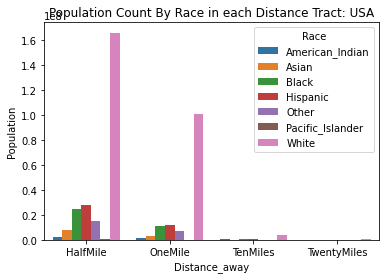

In [22]:
# Visualize population distrbution at each distances
pop_at_each_dist_melted = pd.melt(pop_at_each_dist, id_vars='Race', var_name='Distance_away', value_name='Population')
sns.barplot(data=pop_at_each_dist_melted,x='Distance_away', y='Population', hue='Race').set(title='Population Count By Race in each Distance Tract: USA')
plt.show()

This bar graph displays the population of each race in the US, as highlighted in the legend, in terms of distances from a supermarket.

We also wanted to know the total population we are working with grouped by race so we extracted the population data below.

In [23]:
# Getting the total population of different races in the US from the original dataset
%sql total_population << SELECT TractWhite AS White,TractBlack AS Black, TractAsian AS Asian, TractNHOPI AS Pacific_Islander, \
TractAIAN AS American_Indian, TractOMultir AS Other, TractHispanic AS Hispanic FROM df

total_population = pd.melt(total_population, var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
total_population.to_csv('total_population_df.csv')

total_population

Returning data to local variable total_population


,Race,Population
0,American_Indian,2932248
1,Asian,14674252
2,Black,38929319
3,Hispanic,50477594
4,Other,28116441
5,Pacific_Islander,540013
6,White,223553265


As mentioned above, this data frame represents the total population for each race in the US, as accounted by this dataset.

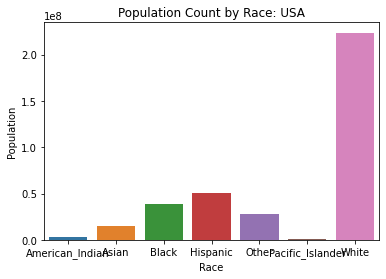

In [24]:
# Visualize population distribution across races
sns.barplot(data=total_population,x='Race', y='Population').set(title='Population Count by Race: USA')
plt.show()

This bar graph showcases the population of each race in the US. As seen, the white population is the highest racial group. 

### NY Data Cleaning

In [25]:
%sql ny_half << SELECT State, County, lawhitehalf as White, lablackhalf as Black, laasianhalf as Asian,\
lanhopihalf as Pacific_Islander, laaianhalf as American_Indian, laomultirhalf as Other, lahisphalf \
as Hispanic FROM df WHERE State = 'New York'
%sql ny_one << SELECT State, County, lawhite1 as White, lablack1 as Black, laasian1 as Asian,\
lanhopi1 as Pacific_Islander, laaian1 as American_Indian, laomultir1 as Other, lahisp1 as Hispanic \
FROM df WHERE State = 'New York'
%sql ny_ten << SELECT State, County, lawhite10 as White, lablack10 as Black, laasian10 as Asian,\
lanhopi10 as Pacific_Islander, laaian10 as American_Indian, laomultir10 as Other, lahisp10 as Hispanic FROM df \
WHERE State = 'New York'
%sql ny_twenty << SELECT State, County, lawhite20 as White, lablack20 as Black, laasian20 as Asian,\
lanhopi20 as Pacific_Islander, laaian20 as American_Indian, laomultir20 as Other, lahisp20 as Hispanic FROM df \
WHERE State = 'New York'

cleaned_ny_half = pd.melt(ny_half, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
cleaned_ny_one = pd.melt(ny_one, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
cleaned_ny_ten = pd.melt(ny_ten, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
cleaned_ny_twenty = pd.melt(ny_twenty, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()

ny_pop_at_each_dist = pd.DataFrame({'Race':cleaned_ny_half['Race'], 'HalfMile':cleaned_ny_half['Population'], \
'OneMile':cleaned_ny_one['Population'],'TenMiles':cleaned_ny_ten['Population'],'TwentyMiles':cleaned_ny_twenty['Population']})
ny_pop_at_each_dist.to_csv('ny_pop_at_each_dist.csv')
ny_pop_at_each_dist

Returning data to local variable ny_half
Returning data to local variable ny_one
Returning data to local variable ny_ten
Returning data to local variable ny_twenty


,Race,HalfMile,OneMile,TenMiles,TwentyMiles
0,American_Indian,3.455974e+04,2.110377e+04,787.270739,1.000088
1,Asian,2.628393e+05,9.479964e+04,346.265939,0.000265
2,Black,5.924514e+05,1.717682e+05,2408.879887,0.715675
3,Hispanic,6.036213e+05,2.148840e+05,2023.171552,4.505039
4,Other,3.583624e+05,1.331233e+05,1583.693025,2.110698
5,Pacific_Islander,2.482825e+03,1.263375e+03,27.135887,0.000000
6,White,6.927099e+06,4.036151e+06,82422.596879,372.440094


This data frame drops several columns and cleans the data to keep the relevant columns to our dataset and to New York. We renamed the race variables to make the race in question more clear. We also used the melt function to aggregate all the distances from a food desert into one column. This data frame displays the columns in terms of New York, which are race and the population counts by various distances.

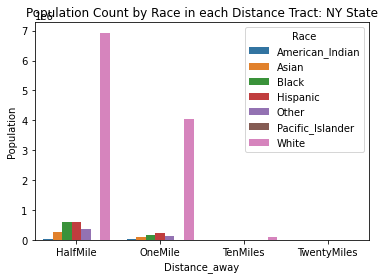

In [26]:
# New York 
ny_pop_at_each_dist_melted = pd.melt(ny_pop_at_each_dist, id_vars='Race', var_name='Distance_away', value_name='Population')
sns.barplot(data=ny_pop_at_each_dist_melted,x='Distance_away', y='Population', hue='Race')\
.set(title='Population Count by Race in each Distance Tract: NY State')
plt.show()

This bar graph display the population of each race within the state of NY, as highlighted in the legend, in terms of distances from a supermarket. 

In [27]:
# NY total population
%sql ny_total_population << SELECT TractWhite AS White,TractBlack AS Black, TractAsian AS Asian, TractNHOPI AS Pacific_Islander, \
TractAIAN AS American_Indian, TractOMultir AS Other, TractHispanic AS Hispanic FROM df WHERE State = 'New York'

ny_total_population = pd.melt(ny_total_population, var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
ny_total_population.to_csv('ny_total_population.csv')
ny_total_population

Returning data to local variable ny_total_population


,Race,Population
0,American_Indian,106906
1,Asian,1420244
2,Black,3073800
3,Hispanic,3416922
4,Other,2027412
5,Pacific_Islander,8766
6,White,12740974


This data frame represents the total population of different races in New York from the original dataset.

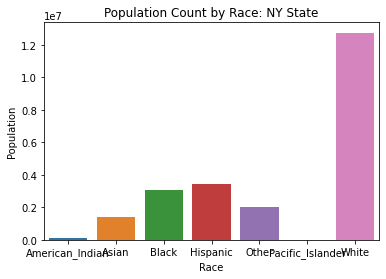

In [28]:
# New York State population distribution
sns.barplot(data=ny_total_population, x='Race', y='Population').set(title='Population Count by Race: NY State')
plt.show()

This bar graph display the population of each race in terms of New York State, as highlighted in the legend, in terms of distances from a supermarket. 